In [39]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from scipy.ndimage import gaussian_filter
from scipy.signal import welch
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from config import *
from functions import *
from sim import *
from read_ramses import *


In [3]:
# choose simulation
sim_round = 13
sim_name = "lowturb"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(aexp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.aexp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round13/lowturb'.

Dump: 32
a_exp: 0.0855
Maximum AMR level: 13


In [4]:
data = SimpleNamespace(**np.load('starcat/data.npz'))
data.SFR = data.starmass_hist1d

aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')


In [7]:
median_weighted(data.eps_sf1d, weight=data.eps_sf_hist1d)
cond = data.time1d>aexp_to_proper_time(0.1)-50*const.Myr
print('%.4g'%(np.mean(data.SFR[cond])/(const.M_sol/const.yr)))
print('%.3g'%(100*median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)))


0
13.8


In [6]:
norm_resp_func = lambda resp_func: resp_func / np.sum(resp_func)
data_resp_func = SimpleNamespace(**np.load(os.path.join(analysis_dir, 'resp_func.npz')))

resp_func_list = ['Halpha', 'OIII', 'f200w', 'f277w']
for resp_func_name in resp_func_list:
    
    # interpolate response function to time array
    resp_func_interp = interp1d(data_resp_func.time, getattr(data_resp_func, resp_func_name), fill_value='extrapolate')
    resp_func = norm_resp_func(resp_func_interp(data.time1d))
    
    # convolve response function with SFR
    SFR_conv = np.zeros_like(data.SFR)
    for i in range(SFR_conv.size):
        SFR_conv[i] = np.sum(data.SFR[:i] * resp_func[:i][::-1])
        
    setattr(data, 'SFR_%s' % resp_func_name, SFR_conv)


### SFH

In [10]:
# list of columns in star logs
col_name_list = np.array(["event", "id", "level", "mass", "x_star", "y_star", "z_star", "velx_star", "vely_star", "velz_star", "density", "velx", "vely", "velz", "temp", "metallicity", "energy_turb", "mask", "b_turb", "tag", "time"])
col_unit_list = np.array(["dimless", "dimless", "dimless", "mass", "length", "length", "length", "vel", "vel", "vel", "density", "vel", "vel", "vel", "dimless", "dimless", "spec_energy", "dimless", "dimless", "dimless", "dimless"])

for ncpu in range(0, 10):
    
    filename = "output_%.5d/stars_%.5d.out%.5d" % (dump, dump, ncpu)
    if not os.path.isfile(filename): continue # skip if star log file does not exist
    if get_numline(filename) <= 1: continue # skip if star log file is empty

    # read the star log
    stardata_tab = ascii.read(filename, names=col_name_list, data_start=1)

    # preprocess star log data
    stardata = {}
    for col_name in col_name_list:
        if col_name != 'mask': # mask data is sometimes corrupted
            stardata[col_name] = np.array(stardata_tab[col_name].data, dtype=float)
    if stardata['id'].size == 0: continue # skip if star data is empty
        

Text(0.5, 0, '$a_{\\rm exp}$')

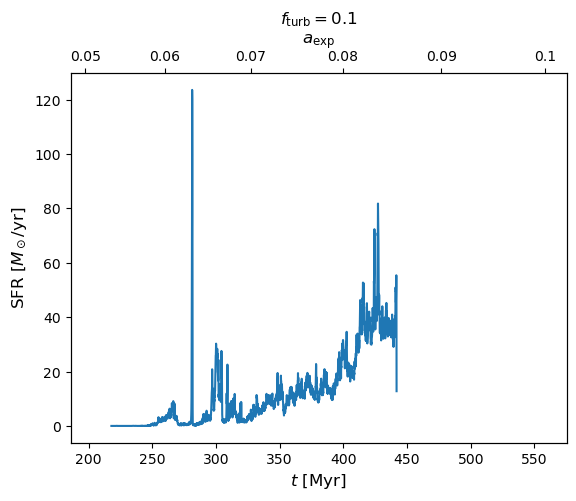

In [13]:
# define aexp ticks
aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

# create axes
ax1 = plt.gca()
ax2 = ax1.twiny()

# plot SFR
cond = (data.SFR > 0)
ax1.plot(data.time1d_death[cond] / const.Myr, data.SFR[cond] / (const.M_sol / const.yr), lw=1.5, color='C0')

# set up primary axis
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_title(sim_latex)

# set up seconary axis
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

#ax1.set_yscale('log')
#ax3.set_yscale('log')
#ax1.set_xlim(460, 480)
#ax1.set_ylim(40, 100)

#save_fig('SFRandSNe_mstar1p0')


Saved figure as 'SFR_fid-040920241758.png'


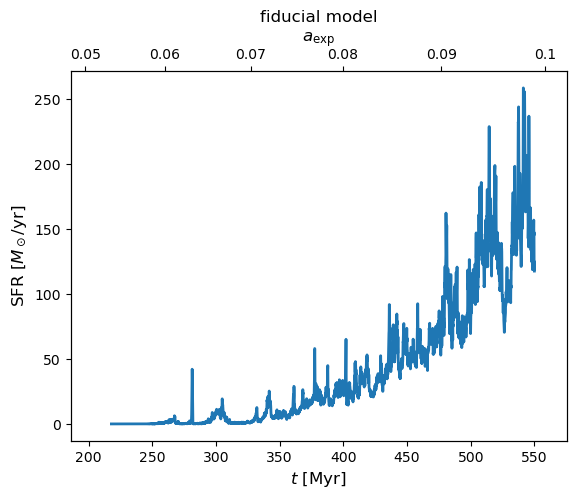

In [20]:
# define aexp ticks
aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

# create axes
ax1 = plt.gca()
ax2 = ax1.twiny()
ax3 = ax1.twinx()

# plot SFR
cond = (data.SFR > 0)
ax1.plot(data.time1d[cond] / const.Myr, data.SFR[cond] / (const.M_sol / const.yr), lw=2, color='C0')

# set up primary axis
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_title(sim_latex)

# set up seconary axis
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

#save_fig('SFR_fid')


Text(0.5, 0, '$a_{\\rm exp}$')

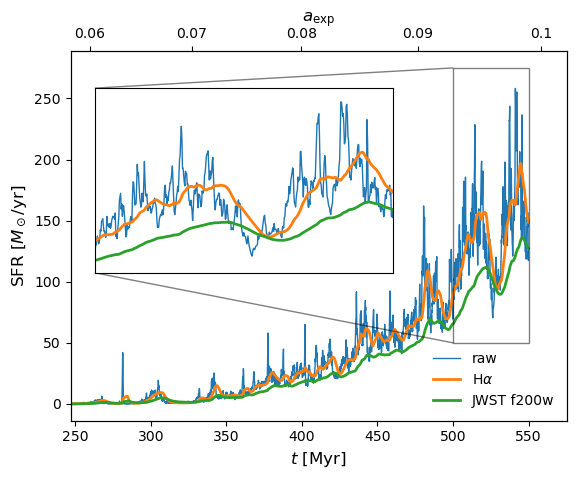

In [7]:
# define aexp ticks
aexp_min = 0.058
aexp_max = 0.102
tick_aexp = np.arange(0.06, 0.1 + 0.01, 0.01)

# list response functions
resp_func_list = [(r'H$\alpha$', 'Halpha'), ('JWST f200w', 'f200w')]

# create axes
fig = plt.figure()
ax1 = plt.gca()
ax2 = ax1.twiny()
ax3 = ax1.inset_axes([0.05, 0.4, 0.6, 0.5], xlim=(500, 550), ylim=(50, 275), xticks=[], yticks=[])

# plot raw SFR
ax1.plot(data.time1d / const.Myr, data.SFR / (const.M_sol / const.yr), label='raw', lw=1)
ax3.plot(data.time1d / const.Myr, data.SFR / (const.M_sol / const.yr), lw=1)

for resp_func_label, resp_func_name in resp_func_list:

    # plot convolved SFR
    SFR_conv = getattr(data, 'SFR_%s' % resp_func_name)
    ax1.plot(data.time1d / const.Myr, SFR_conv / (const.M_sol / const.yr), label=resp_func_label, lw=2)
    ax3.plot(data.time1d / const.Myr, SFR_conv / (const.M_sol / const.yr), lw=2)

# set up inset axis
ax1.indicate_inset_zoom(ax3, edgecolor="black")
    
# set up primary axis
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.legend(loc=4, frameon=False)

# set up seconary axis
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

#save_fig('SFR_conv')


/tmp/ipykernel_3897041/2660342392.py:5: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_3897041/2660342392.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)


Text(0.5, 1.0, 'no photoionization')

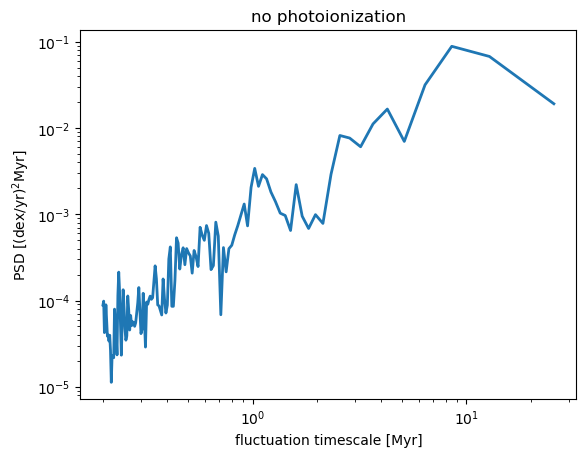

In [11]:
fac_ds = 1
time1d_ds, SFR_ds = downsample_hist(data.time1d, data.SFR, fac_ds=fac_ds)

cond = (time1d_ds > 300 * const.Myr) * (SFR_ds > 0)
log_SFR = np.log10(SFR_ds)
freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')

plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex/yr)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(sim_latex)

# save_fig("SFR-dxmin")


/tmp/ipykernel_1640058/593483211.py:5: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_1640058/593483211.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label='raw')
/tmp/ipykernel_1640058/593483211.py:12: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_conv)
/tmp/ipykernel_1640058/593483211.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=resp_func_label)


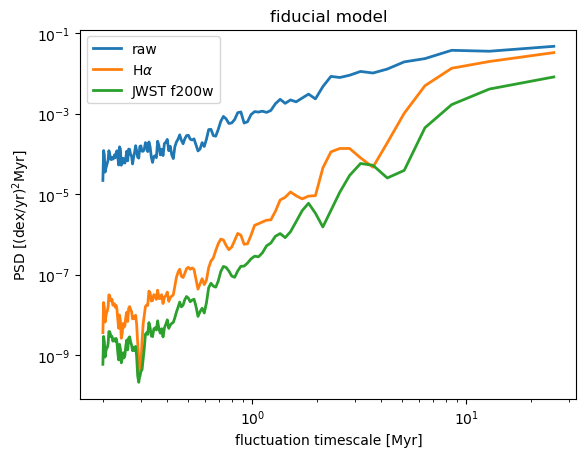

In [11]:
# list response functions
resp_func_list = [(r'H$\alpha$', 'Halpha'), ('JWST f200w', 'f200w')]

cond = (data.time1d > 350 * const.Myr)
log_SFR = np.log10(SFR_ds)
freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')
plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label='raw')

for resp_func_label, resp_func_name in resp_func_list:

    SFR_conv = getattr(data, 'SFR_%s' % resp_func_name)
    log_SFR = np.log10(SFR_conv)
    freq, psd = welch(log_SFR[cond], 1/(data.time1d[1] - data.time1d[0]), detrend='linear')
    plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=resp_func_label)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex/yr)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(sim_latex)
plt.legend()

#save_fig('SFRpsd_conv')


Text(0.5, 0, '$a_{\\rm exp}$')

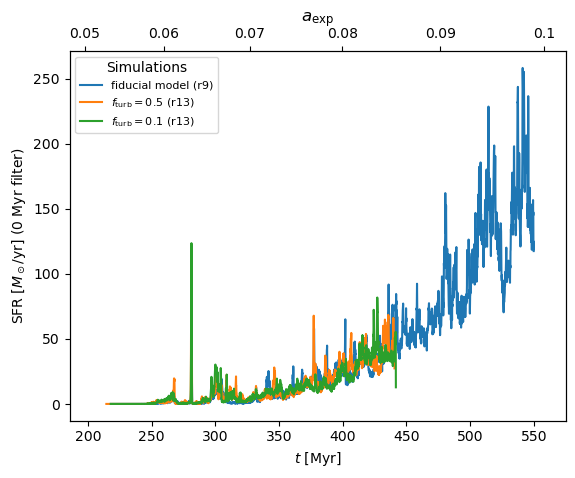

In [14]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]
fsigma = 0 * const.Myr

aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

ax1 = plt.gca()

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d
    SFR_sm = gaussian_filter(data.SFR, sigma=(fsigma / np.diff(data.time1d)[0]))
    
    cond = (SFR_sm > 0)
    ax1.plot(data.time1d[cond] / const.Myr, SFR_sm[cond] / (const.M_sol / const.yr), lw=1.5, label=sim_latex+" (r%d)"%sim_round)

ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_xlabel(r"$t$ [Myr]")
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$] ($%.2g~{\rm Myr}$ filter)" % (fsigma / const.Myr))
ax1.legend(title='Simulations', fontsize=8)
#ax1.set_yscale('log')

ax2 = ax1.twiny()
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

#ax1.set_xlim(250, 400)
#ax1.set_ylim(-1, 31)
    
#save_fig("SFR_comp")
    

Saved figure as 'starmass_fid-040920241804.png'


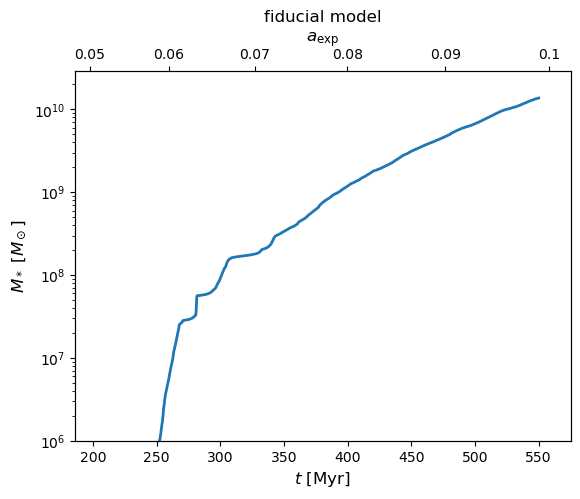

In [30]:
sim_list = [(9, "fiducial")]

# define aexp ticks
aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

# create axes
ax1 = plt.gca()
ax2 = ax1.twiny()

# set up primary axis
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_ylabel(r"$M_*$ [$M_\odot$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_title(sim_latex)
ax1.set_yscale('log')

# set up seconary axis
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    starmass = np.cumsum(data.starmass_hist1d) * np.diff(data.time1d)[0]
    
    cond = data.starmass_hist1d > 0
    plt.plot(data.time1d[cond] / const.Myr, starmass[cond] / (const.M_sol), label=sim_latex + " (r%d)" % sim_round, lw=2)
    
#plt.legend(title='Simulations', fontsize=8, loc=2)
#plt.xlim(240, 300)
plt.ylim(1e6);
#plt.ylim(0, 10)

#save_fig('starmass_comp')
save_fig('starmass_fid')


/tmp/ipykernel_3897041/1409320174.py:15: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_3897041/1409320174.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)


Saved figure as 'psd_comp-031420241157.png'


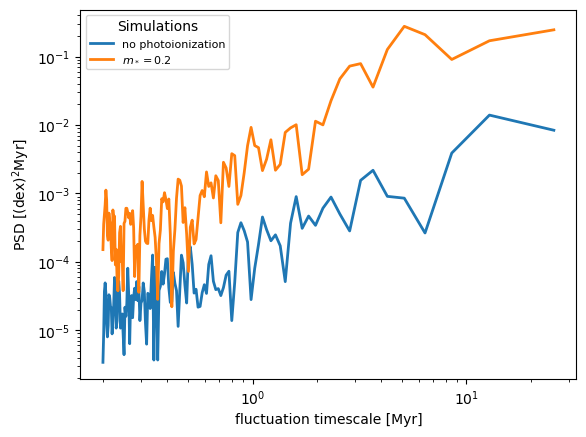

In [27]:
sim_list = [(12, "nophot"), (9, "mstar0p2")]
fac_ds = 1
time_min = 325 * const.Myr
time_max = 375 * const.Myr

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d 
    time1d_ds, SFR_ds = downsample_hist(data.time1d, data.SFR, fac_ds=fac_ds)

    cond = (time1d_ds > time_min) * (time1d_ds < time_max)
    log_SFR = np.log10(SFR_ds)
    freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')
    plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Simulations', fontsize=8)

save_fig('psd_comp')


### PDF

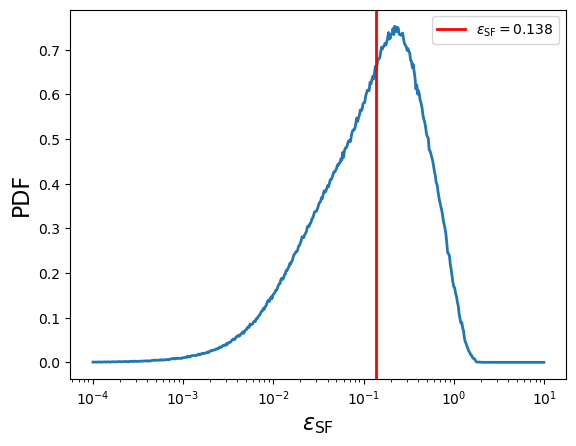

In [103]:
plt.plot(data.eps_sf1d, data.eps_sf_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$', fontsize=16)
plt.ylabel('PDF', fontsize=16)

eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
plt.axvline(x=eps_sf_median, lw=2, color='red')
add_custleg_to_ax([r'$\varepsilon_{\rm SF} = %.3g$' % eps_sf_median], ['red'])

#plt.axvline(x=0.1, lw=2, color='red')


Text(0, 0.5, 'PDF')

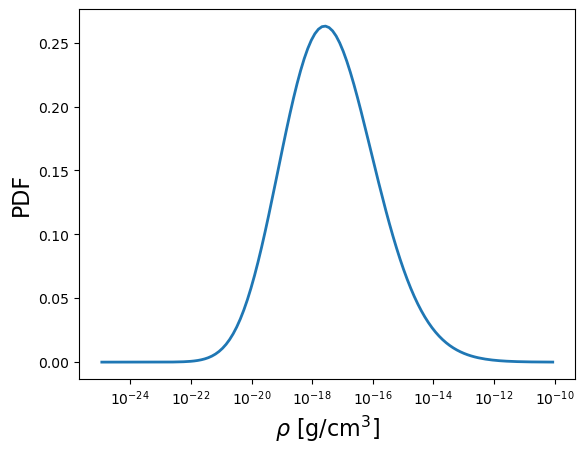

In [102]:
plt.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)

# eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
# plt.axvline(x=eps_sf_median, lw=2, color='red')
# add_custleg_to_ax([r'$\varepsilon_{\rm SF} = %.3g$' % eps_sf_median], ['red'])


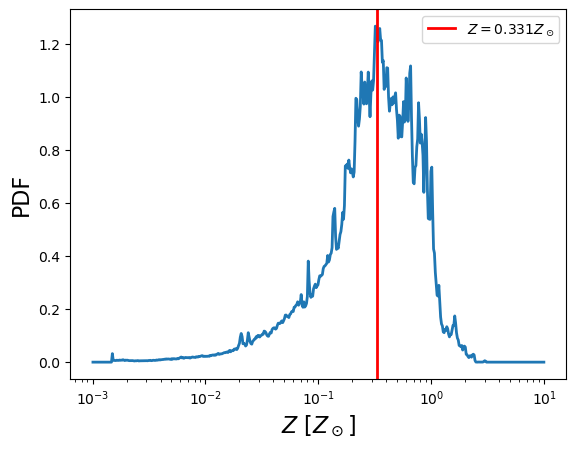

In [25]:
plt.plot(data.metallicity1d / const.Z_sol, data.metallicity_pdf1d, lw=2)
#plt.plot(data.metallicity1d_death / const.Z_sol, data.metallicity_pdf1d_death, lw=2)
plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)

metallicity_median = median_weighted(data.metallicity1d, data.metallicity_pdf1d)
plt.axvline(x=metallicity_median / const.Z_sol, lw=2, color='red')
add_custleg_to_ax([r'$Z = %.3g Z_\odot$' % (metallicity_median / const.Z_sol)], ['red'])

#save_fig('metallicity_star')


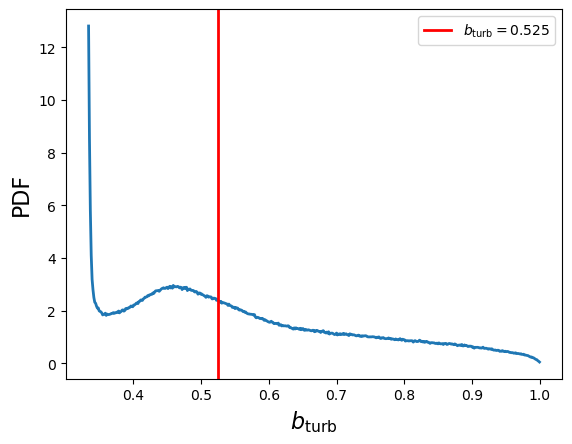

In [100]:
plt.plot(data.b_turb1d, data.b_turb_pdf1d, lw=2)
plt.xlabel(r'$b_{\rm turb}$', fontsize=16)
plt.ylabel('PDF', fontsize=16)

b_turb_median = median_weighted(data.b_turb1d, data.b_turb_pdf1d)
plt.axvline(x=b_turb_median, lw=2, color='red')
add_custleg_to_ax([r'$b_{\rm turb} = %.3g$' % b_turb_median], ['red'])


Text(0.5, 1.0, 'fiducial model')

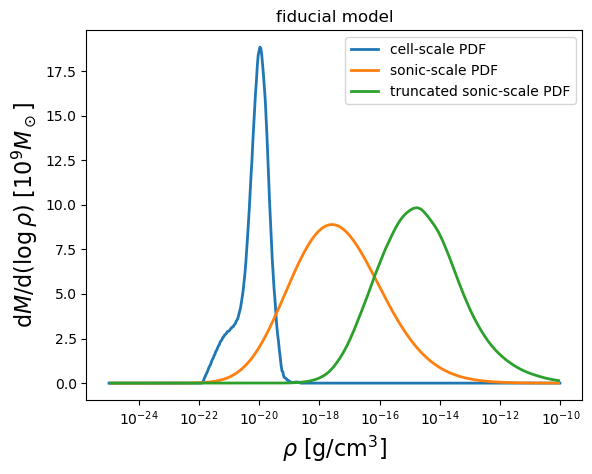

In [99]:
unit = 1e9*const.M_sol

plt.plot(data.density1d, data.density_hist1d/unit, lw=2, label='cell-scale PDF')
plt.plot(data.density_mff1d, data.density_mff_hist1d/unit, lw=2, label='sonic-scale PDF')
plt.plot(data.density_mff_trunc1d, data.density_mff_trunc_hist1d/unit, lw=2, label='truncated sonic-scale PDF')

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^{3}}$]', fontsize=16)
plt.ylabel(r'${\rm d}M/{\rm d}(\log \rho)$ [$10^9 M_\odot$]', fontsize=16)
plt.legend()
plt.title('fiducial model')


Text(0, 0.5, 'PDF')

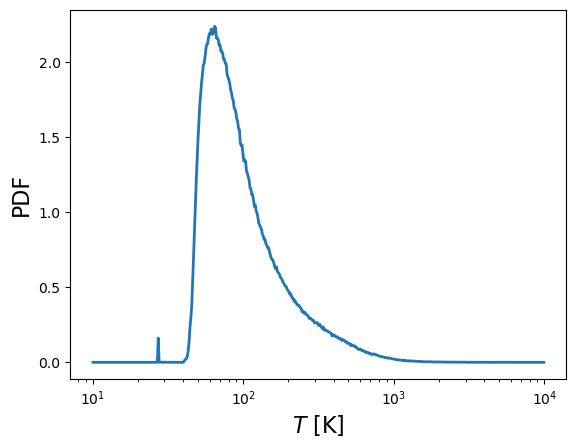

In [9]:
plt.plot(data.temp1d, data.temp_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)


Text(0, 0.5, 'PDF')

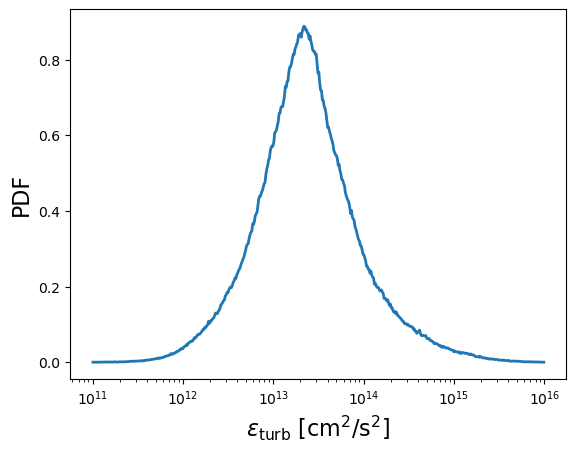

In [97]:
plt.plot(data.energy_turb1d, data.energy_turb_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm turb}$ [${\rm cm^2/s^2}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)


Saved figure as 'mach_turb_comp-031320241100.png'


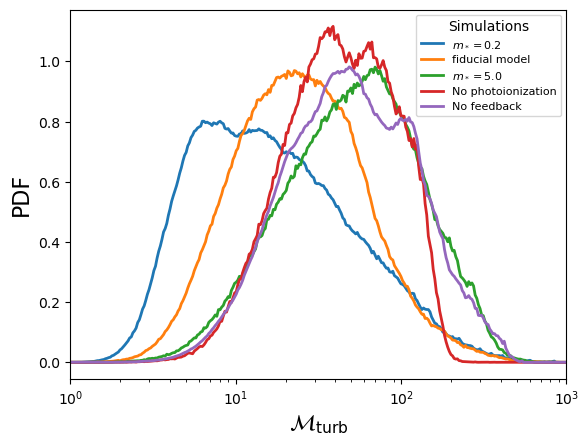

In [99]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (12, "nofeed")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.mach_turb1d, sim.data.mach_turb_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm turb}$', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=8)

plt.xlim(1e0, 1e3)
save_fig('mach_turb_comp')


Saved figure as 'temp_comp-090320241315.png'


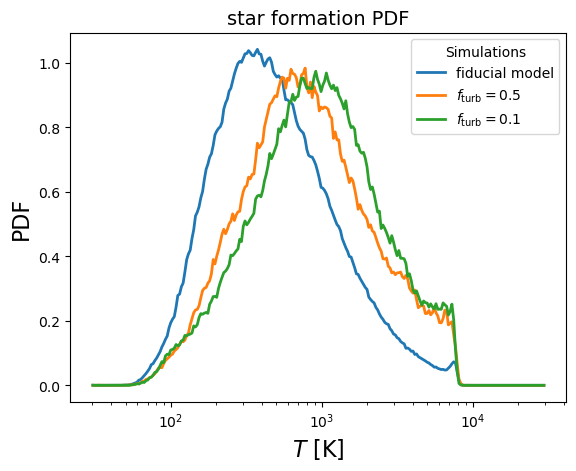

In [43]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.temp1d, sim.data.temp_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=10)

plt.title("star formation PDF", fontsize=14)

save_fig('temp_comp')


Saved figure as 'sigturb_comp-090320241002.png'


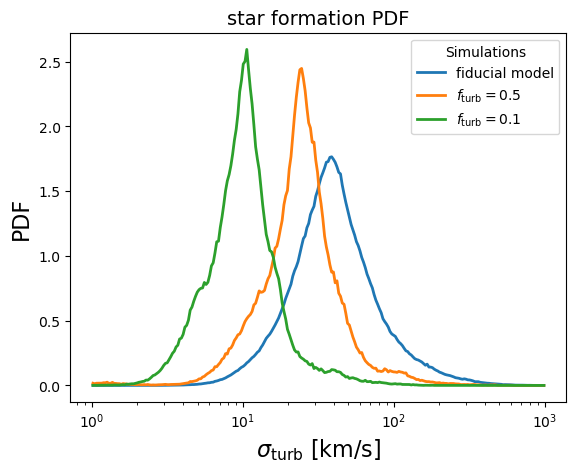

In [23]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.sig_turb1d / const.km, sim.data.sig_turb_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$\sigma_{\rm turb}$ [${\rm km/s}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=10)

plt.title("star formation PDF", fontsize=14)

save_fig('sigturb_comp')


AttributeError: 'types.SimpleNamespace' object has no attribute 'density_mff1d'

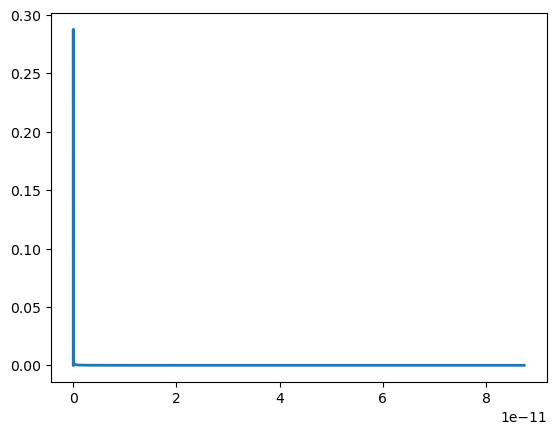

In [4]:
sim_list = [(9, "instantfeedback"), (9, "fastfeedback"), (9, "fiducial")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.density_mff1d, sim.data.density_mff_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=10)

#save_fig('rhomff-comp2')


Saved figure as 'rho_comp-090320241003.png'


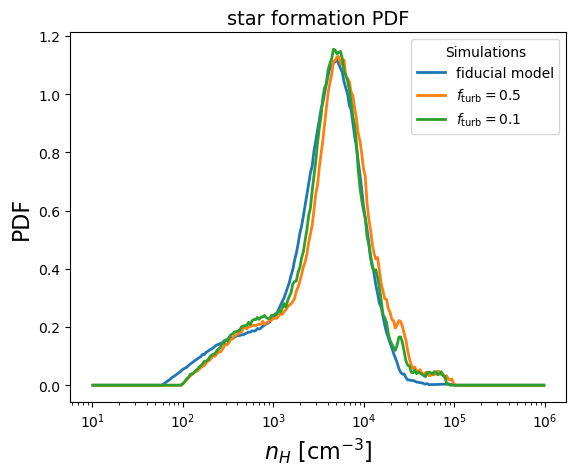

In [28]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.nH1d, sim.data.nH_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=10)

plt.title("star formation PDF", fontsize=14)

save_fig('rho_comp')

#save_fig('rho-comp')


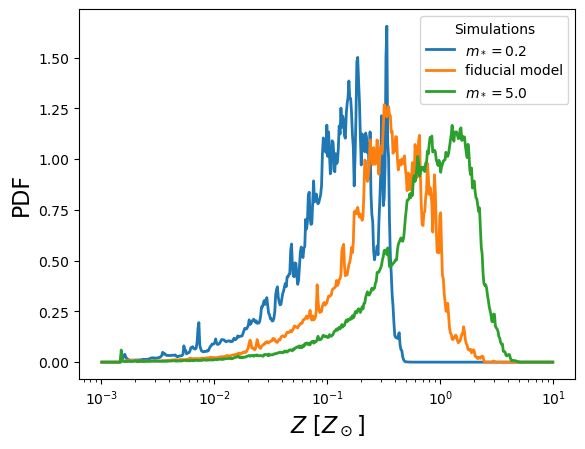

In [91]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.metallicity1d/const.Z_sol, sim.data.metallicity_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=10)

#save_fig('Z-comp')


Saved figure as 'SNe_nH-042220241745.png'


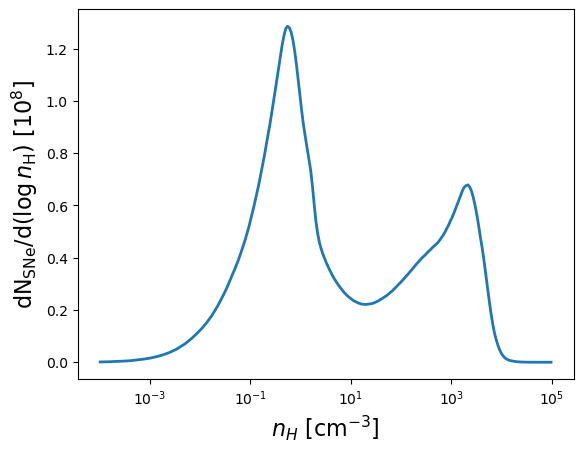

In [13]:
sim_list = [(9, "fiducial")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.nH1d_death, sim.data.nH_hist1d_death/1e8, lw=2)

plt.xscale('log')
plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=16)
plt.ylabel(r'${\rm d}{\rm N_{\rm SNe}}/{\rm d}(\log n_{\rm H})$ [$10^8$]', fontsize=16)

save_fig('SNe_nH')


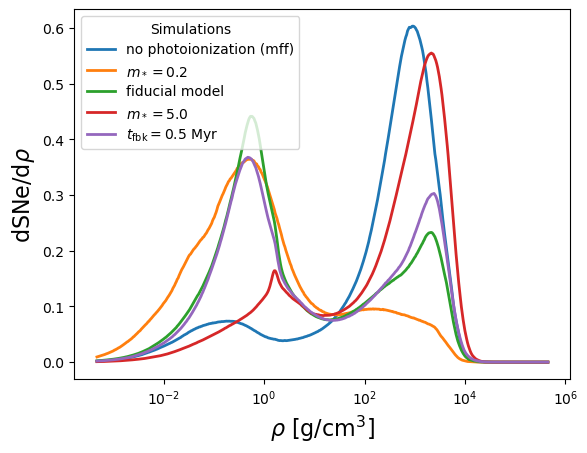

In [11]:
sim_list = [(12, "nophot"), (9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (9, "fastfeedback")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.density1d_death*const.X_cosmo/const.m_H, sim.data.density_pdf1d_death, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]', fontsize=16)
plt.ylabel(r'${\rm d}{\rm SNe}/{\rm d}\rho$', fontsize=16)
plt.legend(title='Simulations', fontsize=10)

#save_fig('rhoSNe-comp')


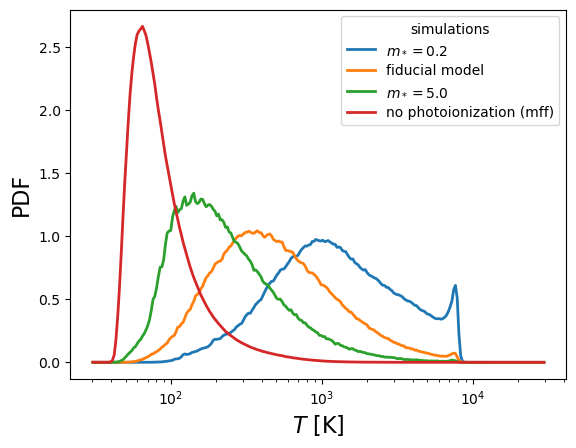

In [8]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.temp1d, sim.data.temp_pdf1d, lw=2, label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='simulations', fontsize=10)

# save_fig('temp-comp')


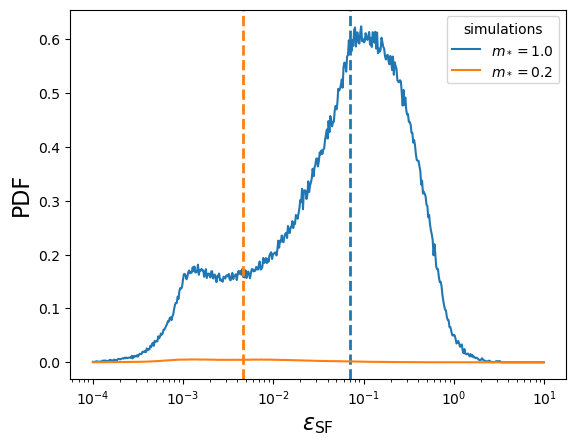

In [87]:
sim_list = [(11, "mstar1p0"), (11, "mstar0p2")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.eps_sf1d, sim.data.eps_sf_pdf1d, lw=1.5, label=sim.latex)
    eps_sf_median = median_weighted(sim.data.eps_sf1d, sim.data.eps_sf_pdf1d)
    plt.axvline(x=eps_sf_median, lw=2, color='C%d' % i, linestyle='--')

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='simulations', fontsize=10)

#save_fig('epssf_mffvconst')


Saved figure as 'eps_comp-090320241005.png'


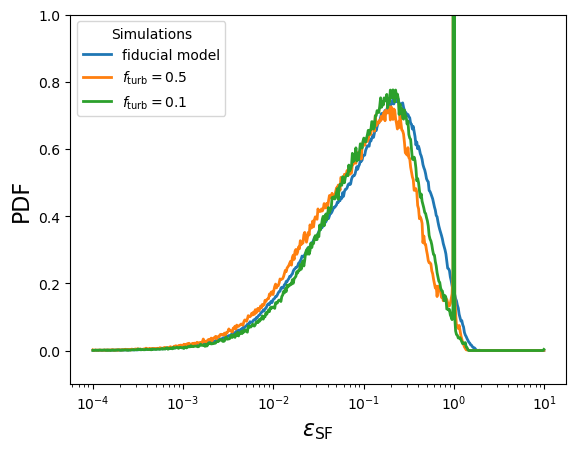

In [38]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]

for i, sim in simloop(sim_list):
    plt.plot(sim.data.eps_sf1d, sim.data.eps_sf_pdf1d, lw=2., label=sim.latex)

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(title='Simulations', fontsize=10)
plt.ylim(-0.1, 1)

save_fig('eps_comp')


### phase space

Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


Text(0.5, 1.0, 'fiducial model')

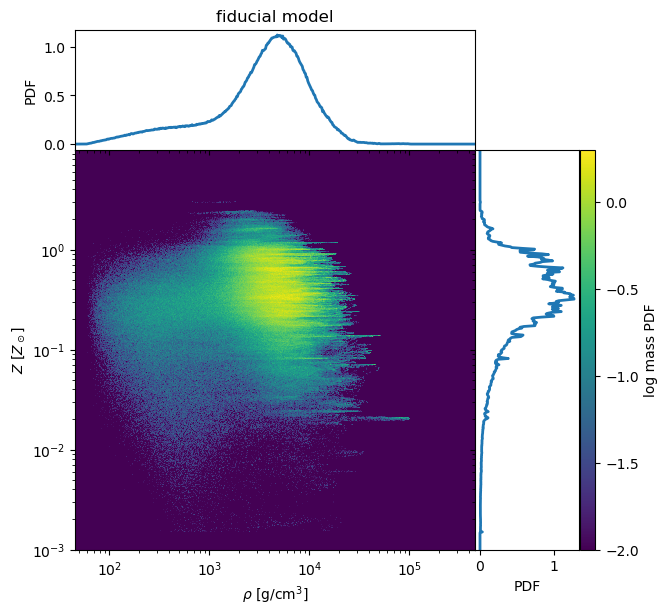

In [160]:
sim_round = 9
sim_name = 'fiducial'
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

axs, im = plot_hist2d(const.X_cosmo*data.density2d/const.m_H, data.metallicity2d/const.Z_sol, data.density_metallicity_pdf2d.T, vmin=1e-2, vmax=2e0);

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')
axs[0].set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
axs[0].set_ylabel(r'$Z$ [$Z_\odot$]')
axs[1].set_ylabel('PDF')
axs[2].set_xlabel('PDF')
axs[1].set_title(sim_name_to_latex[sim_name])

# save_fig('phase_rho_metal')


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Saved figure as 'phase_metal_mach-030120241302.png'


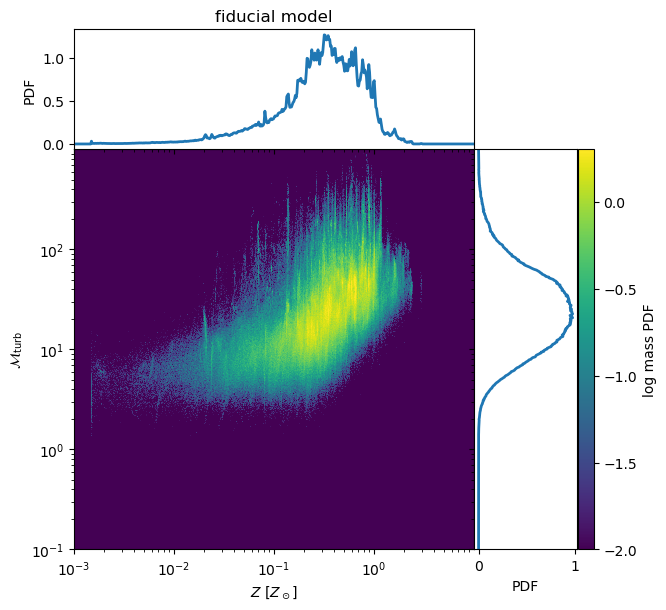

In [111]:
sim_round = 9
sim_name = 'fiducial'
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

axs, im = plot_hist2d(data.metallicity2d/const.Z_sol, data.mach_turb2d, data.metallicity_mach_turb_pdf2d.T, vmin=1e-2, vmax=2e0);

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')
axs[0].set_xlabel(r'$Z$ [$Z_\odot$]')
axs[0].set_ylabel(r'$\mathcal{M}_{\rm turb}$')
axs[1].set_ylabel('PDF')
axs[2].set_xlabel('PDF')
axs[1].set_title(sim_name_to_latex[sim_name])

save_fig('phase_metal_mach')


Moving to directory '/home/za9132/scratch/romain/round12/nophot'.


Text(0.5, 1.0, 'no photoionization')

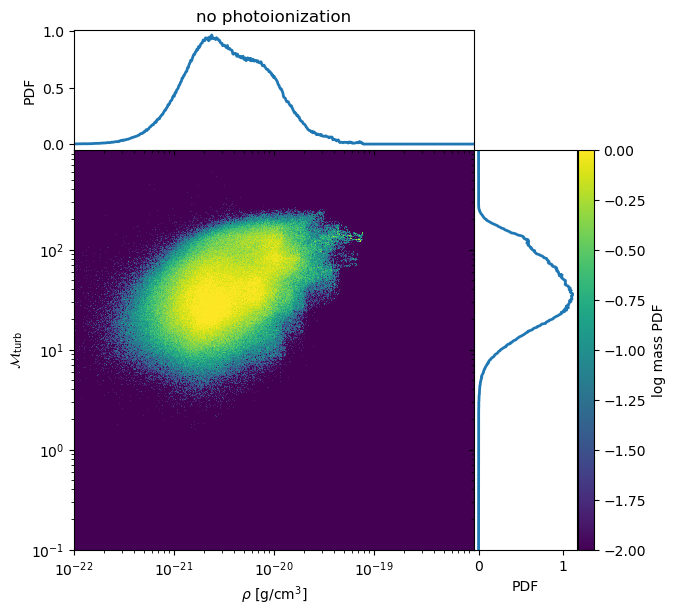

In [8]:
sim_round = 12
sim_name = 'nophot'
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

axs, im = plot_hist2d(data.density2d, data.mach_turb2d, data.density_mach_turb_pdf2d.T, vmin=1e-2, vmax=1e0);

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')
axs[0].set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
axs[0].set_ylabel(r'$\mathcal{M}_{\rm turb}$')
axs[1].set_ylabel('PDF')
axs[2].set_xlabel('PDF')
axs[1].set_title(sim_name_to_latex[sim_name])

#save_fig('phase_rho_mach_turb')


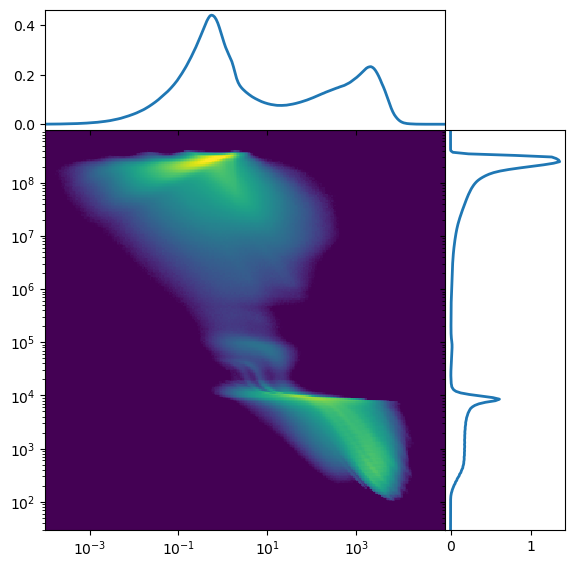

In [8]:
plot_hist2d(data.nH2d_death, data.temp2d_death, data.nH_temp_pdf2d_death.T, vmin=1e-3, vmax=2e0);


In [6]:
sim_round = 9
sim_name = 'fiducial'
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

axs, im = plot_hist2d(data.density2d*const.X_cosmo/const.m_H, data.temp2d, data.density_temp_pdf2d.T, vmin=1e-3, vmax=2e0);

dx = 10*const.pc
mstar = 3000*const.M_sol
t_fbk = 0.5*const.Myr
b_turb = 1.0
mach_turb = 10
density2d, temp2d = np.meshgrid(data.density2d, data.temp2d, indexing='ij') 
energy_turb = 3/2 * const.k_B * temp2d * mach_turb**2 / const.m_p
eps_sf = calc_eps_sf2(density2d, energy_turb, temp2d, dx, b_turb)
Mstar = 1/np.log(2)*np.sqrt(32*const.G/(3*np.pi)) * eps_sf * density2d**(3/2) * dx**3 * t_fbk
#axs[0].contour(density2d*const.X_cosmo/const.m_H, temp2d, Mstar, levels=[mstar], colors='red', linewidths=2)

# pres_fbk = (22*const.km)**2
# temp_fbk = const.m_H * pres_fbk / (const.k_B)
# axs[0].axhline(y=temp_fbk, color='red')

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')
axs[0].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]')
axs[0].set_ylabel(r'$T / \mu$ [${\rm K}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
axs[1].set_title(sim_name_to_latex[sim_name])

# save_fig('phase_dens_temp_nophotconst')


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


AttributeError: 'types.SimpleNamespace' object has no attribute 'density2d'

Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


<a list of 3 text.Text objects>

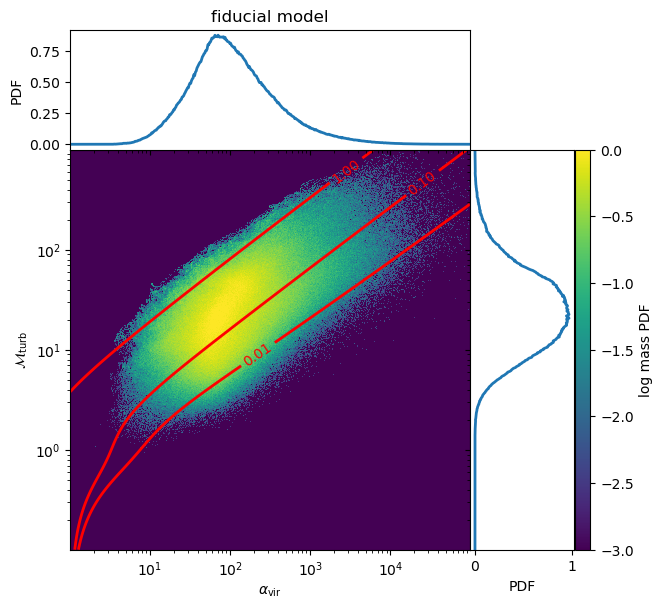

In [42]:
sim_round = 9
sim_name = 'fiducial'
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))
b_turb = 1.0

axs, im = plot_hist2d(data.alpha_vir2d, data.mach_turb2d, data.alpha_vir_mach_turb_pdf2d.T, vmin=1e-3, vmax=1e0);

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')
axs[0].set_xlabel(r'$\alpha_{\rm vir}$')
axs[0].set_ylabel(r'$\mathcal{M}_{\rm turb}$')
axs[1].set_ylabel('PDF')
axs[2].set_xlabel('PDF')
axs[1].set_title(sim_name_to_latex[sim_name])

add_custleg_to_ax([r'$\varepsilon_{\rm SF}$'], ['red'], ax=ax1, loc=2)
alpha_vir2d, mach_turb2d = np.meshgrid(data.alpha_vir2d, data.mach_turb2d)
eps_sf = calc_eps_sf(alpha_vir2d, mach_turb2d, b_turb=b_turb)
cs = axs[0].contour(alpha_vir2d, mach_turb2d, eps_sf, levels=[1e-2, 1e-1, 1e0], colors='red', linewidths=2)
plt.clabel(cs, [1e-2, 1e-1, 1e0])

#save_fig('phase_mstar5p0')


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Saved figure as 'phase_nHncool-030120241533.png'


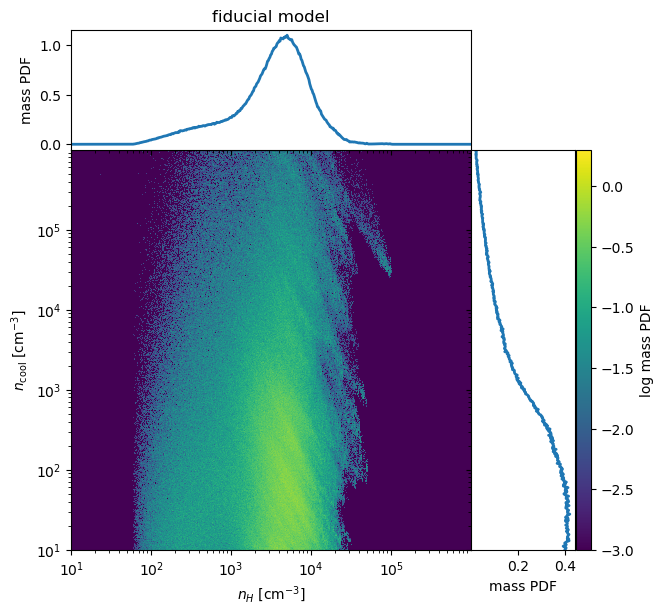

In [199]:
sim_round = 9
sim_name = 'fiducial'
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

axs, im = plot_hist2d(data.nH2d, data.ncool2d, data.nH_ncool_pdf2d.T, vmin=1e-3, vmax=2e0);

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')
axs[0].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]')
axs[0].set_ylabel(r'$n_{\rm cool}$ [${\rm cm^{-3}}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
axs[1].set_title(sim_name_to_latex[sim_name])

save_fig('phase_nHncool')


In [162]:
density2d, metallicity2d = np.meshgrid(data.density2d, data.metallicity2d)
corrw_dens_metal = calc_corrw(density2d, metallicity2d, data.density_metallicity_pdf2d)

density2d, mach_turb2d = np.meshgrid(data.density2d, data.mach_turb2d)
corrw_dens_mach = calc_corrw(density2d, mach_turb2d, data.density_mach_turb_pdf2d)

metallicity2d, mach_turb2d = np.meshgrid(data.metallicity2d, data.mach_turb2d)
corrw_metal_mach = calc_corrw(metallicity2d, mach_turb2d, data.metallicity_mach_turb_pdf2d)

pcorrw_dens_metal_mach = (corrw_dens_metal - corrw_dens_mach * corrw_metal_mach) / np.sqrt(1 - corrw_dens_mach**2) / np.sqrt(1 - corrw_metal_mach**2)

print('correlation dens metal: %.4g' % corrw_dens_metal)
print('correlation dens mach: %.4g' % corrw_dens_mach)
print('correlation metal mach: %.4g' % corrw_metal_mach)
print('correlation dens metal: %.4g' % pcorrw_dens_metal_mach)


correlation dens metal: -0.102
correlation dens mach: 0.2869
correlation metal mach: 0.3296
correlation dens metal: -0.2174
